In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import gurobipy as gp 
from gurobipy import Model, GRB, quicksum

In [3]:
pip install geopy


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

In [5]:
df = pd.read_excel("/Users/niloysmac/Dropbox/FA Project/FBCEBC/RegressionData/modeldata.xlsx")

def haversine_distance(coord1, coord2):
    return geodesic(coord1, coord2).miles

# Create an empty distance matrix DataFrame
num_coordinates = len(df)
distance_matrix = pd.DataFrame(index=range(num_coordinates), columns=range(num_coordinates))

# Populate the distance matrix
for i in range(num_coordinates):
    for j in range(num_coordinates):
        coord1 = (df['Latitude.1'][i], df['Longitude.1'][i])
        coord2 = (df['Latitude.1'][j], df['Longitude.1'][j])
        distance_matrix.at[i, j] = haversine_distance(coord1, coord2)



In [6]:
distance_matrix = distance_matrix.iloc[75:95,75:85]
distance_matrix.shape

(20, 10)

In [7]:
num_coordinates2 = len(df)
distance_matrix2 = pd.DataFrame(index=range(num_coordinates2), columns=range(1))

# Populate the distance matrix
for i in range(num_coordinates):
        coord1 = (df['Latitude.1'][i], df['Longitude.1'][i])
        coord2 = (35.792790,-78.641840)
        distance_matrix2.at[i, 0] = haversine_distance(coord1, coord2)

In [8]:
 distance_matrix2

,0
0,0.846639
1,0.386812
2,0.417639
3,1.245106
4,1.28549
...,...
128,4.72207
129,8.601968
130,0.553046
131,7.598565


In [9]:
#Popup market limit
B= 10
Kit = 1600
Qit = 1600
k = .1
#to array
dij = distance_matrix.to_numpy();
C = distance_matrix2.to_numpy();
pit = np.zeros((dij.shape[0],7))
M = 10000000
dij.shape

C = np.ravel(C)

In [12]:
C = C[]

1.7600318297712358

In [13]:
demand = df['Demand']

In [14]:
demand.shape

(133,)

In [15]:
demand = demand[:88]

In [19]:
demand.shape

(88,)

In [20]:
Dj = demand.to_numpy()

In [21]:
Dj.shape

(88,)

In [22]:
for i in range(len(pit)):
    # For each row, randomly assign 0 or 1 for columns where i is in the range [0, 72]
    for j in range(len(pit[i])):
        if i >= 88:
            pit[i, j] = np.random.randint(0, 2)


In [23]:
# Set print options to display the entire array
np.set_printoptions(threshold=np.inf)
pit.shape

(133, 7)

In [33]:
#Set definition
i = dij.shape[0]                        #Number of potentital locations
j = dij.shape[1]                        #Number of demand nodes

I=[i for i in range(0,i)];
J=[j for j in range(0,j)];
T = [t for t in range(0,pit.shape[1])];

In [34]:
#Model definition
mdl=Model('popup')

In [35]:
JT=[(j,t) for j in J for t in T]
IJT = [(i,j,t) for i in I for j in J for t in T]
IT = [(i,t) for i in I for t in T]

In [36]:
#Decision Variables
x = mdl.addVars(IT, vtype=GRB.BINARY)      
y = mdl.addVars(IJT, vtype=GRB.BINARY) 
v = mdl.addVars(IJT, vtype=GRB.BINARY) 
z = mdl.addVars(IJT, vtype=GRB.CONTINUOUS) 
w = mdl.addVars(IJT, vtype=GRB.CONTINUOUS) 

In [38]:
#Objective
obj1 = sum((dij[i, j] * (y[i, j, t] + v[i, j, t])) for i in I for j in J for t in T)
obj2 = sum((C[i] * x[i,t]) for i in I for t in T)
obj3 = sum((Dj[j] - (w[i,j,t]+z[i,j,t])) for i in I for j in J for t in T)

mdl.setObjective( obj1/53 + obj2/16 + obj3/4809, GRB.MINIMIZE) 

In [44]:
#constatint
# popup market limit for a period t 
mdl.addConstrs((quicksum(x[i,t] for i in I) <= B) for t in T)

# pop-up market at i location at period t has to be open, if any of the j location is to serve from i
mdl.addConstrs((quicksum(y[i,j,t] for j in J) <= M* x[i,t]) for i in I for t in T)
mdl.addConstrs((quicksum(v[i,j,t] for j in J) <= M* pit[i,t]) for i in I for t in T)


mdl.addConstrs((quicksum((y[i,j,t] + v[i,j,t]) for i in I) >= 1) for j in J for t in T)

mdl.addConstrs((quicksum(z[i,j,t] for j in J) <= Qit) for i in I for t in T)
mdl.addConstrs((quicksum(w[i,j,t] for j in J) <= Qit) for i in I for t in T)


#Deamnd 

mdl.addConstrs( z[i,j,t] <= Dj[j]* y[i,j,t] for i in I for j in J for t in T)
mdl.addConstrs( w[i,j,t] <= Dj[j]* v[i,j,t] for i in I for j in J for t in T)
mdl.addConstrs( z[i,j,t] + w[i,j,t] <= Dj[j] for i in I for j in J for t in T)

for j in J:
    for j_prime in J:
        if j != j_prime:
            numerator_sum = gp.quicksum((dij[i,j] * (y[i, j, t] + v[i, j, t])) - (dij[i,j_prime] * (y[i, j_prime, t] + v[i, j_prime, t]))for i in I for t in T)
            denominator_sum = gp.quicksum(dij[i,k] * (y[i, k, t] + v[i, k, t])for i in I for k in J for t in T)
            mdl.addConstr(numerator_sum <= .2*denominator_sum)
            mdl.addConstr(numerator_sum >= -.2*denominator_sum)

#mdl.addConstrs( (quicksum(z[i,j,t] + w[i,j,t] for i in I) * quicksum(Dj[m] for m in J) - Dj[j] * quicksum(z[i,m,t] + w[i,m,t] for i in I for m in J) <= k * quicksum(z[i,m,t] + w[i,m,t] for i in I for m in J) * quicksum(Dj[m] for m in J)) for j in J for t in T )
#mdl.addConstrs( (quicksum(z[i,j,t] + w[i,j,t] for i in I) * quicksum(Dj[m] for m in J) - Dj[j] * quicksum(z[i,m,t] + w[i,m,t] for i in I for m in J) >= -k * quicksum(z[i,m,t] + w[i,m,t] for i in I for m in J) * quicksum(Dj[m] for m in J)) for j in J for t in T )



In [1]:
#Solve
mdl.optimize()

NameError: name 'mdl' is not defined

In [63]:
xobj = np.zeros((168))
for i in range (0,168):
    if x[i,0].x == 1:
        print(f"{i+1} = {x[i,0].x}")

12 = 1.0
17 = 1.0
28 = 1.0
33 = 1.0
39 = 1.0
56 = 1.0
70 = 1.0
79 = 1.0
81 = 1.0
117 = 1.0


In [65]:
for i in range (0,168):
    xobj[i]= x[i,0].x

In [68]:
xobj
df = pd.DataFrame({'xobj': xobj})
df.to_excel('xobj.xlsx')

In [71]:
yobj = np.zeros((168,123))
for i in range (0,168):
    for j in range(0,122):
        yobj[i,j]= y[i,j,0].x 
df = pd.DataFrame(yobj)
df.to_excel('yobj.xlsx')          

In [72]:
vobj = np.zeros((168,123))
for i in range (0,168):
    for j in range(0,122):
        vobj[i,j]= v[i,j,0].x 
df = pd.DataFrame(vobj)
df.to_excel('vobj.xlsx')   

In [91]:
net = pd.read_excel('modeldata.xlsx',sheet_name='t=1')
net

,Name,Latitude.1,Longitude.1,Unnamed: 3
0,Census Tract 501,35.780687,-78.639292,0
1,Census Tract 503,35.790588,-78.648173,0
2,Census Tract 504,35.795937,-78.635487,0
3,Census Tract 505,35.797262,-78.620363,0
4,Census Tract 506,35.784987,-78.621056,0
...,...,...,...,...
163,Iglesia Tabernaculo De Restauracion,35.744815,-78.581860,0
164,Springfield Baptist Church,35.697632,-78.542853,0
165,Open Table,35.790954,-78.632256,0
166,Celebration Church,35.866924,-78.541695,0


In [108]:
import pandas as pd
import networkx as nx
# Create a graph
G = nx.Graph()

# Add nodes
for idx, row in net.iterrows():
    G.add_node(row['Name'], pos=(row['Longitude.1'], row['Latitude.1']))

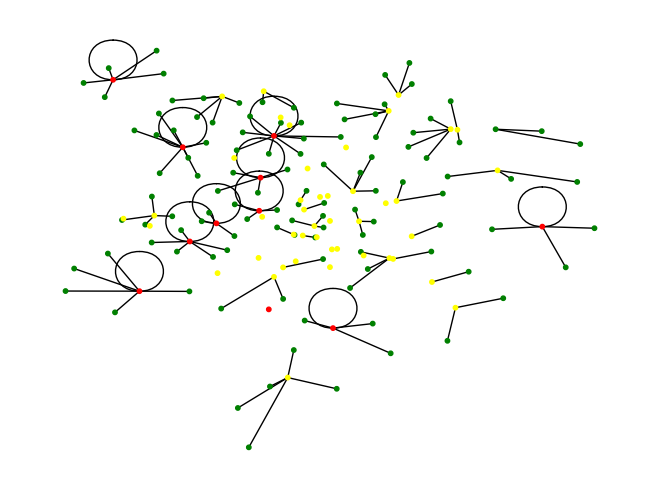

In [127]:
# Iterate through DataFrame
for index, row in net.iterrows():
    name = row['Name']
    lat = row['Latitude.1']
    lon = row['Longitude.1']
    
    if name.startswith('Pop'):
        node_color = 'red'
    elif name.startswith('Cen'):
        node_color = 'green'
    else:
        node_color = 'yellow'
        
    G.add_node(name, pos=(lon, lat), color=node_color)


# Draw nodes
pos = nx.get_node_attributes(G, 'pos')
colors = nx.get_node_attributes(G, 'color').values()
nx.draw(G, pos, node_color=list(colors), with_labels=False, node_size=10)

# Show plot|
plt.show()

In [138]:
edge = pd.read_excel('modeldata.xlsx',sheet_name='edge')


In [139]:
edge

,Source,Target
0,Pop1,Census Tract 503
1,Pop1,Census Tract 511.02
2,Pop1,Pop1
3,Pop1,Census Tract 514
4,Pop2,Census Tract 515.01
...,...,...
117,Springfield Baptist Church,Census Tract 528.07
118,Springfield Baptist Church,Census Tract 528.09
119,Open Table,Census Tract 505
120,Celebration Church,Census Tract 540.23


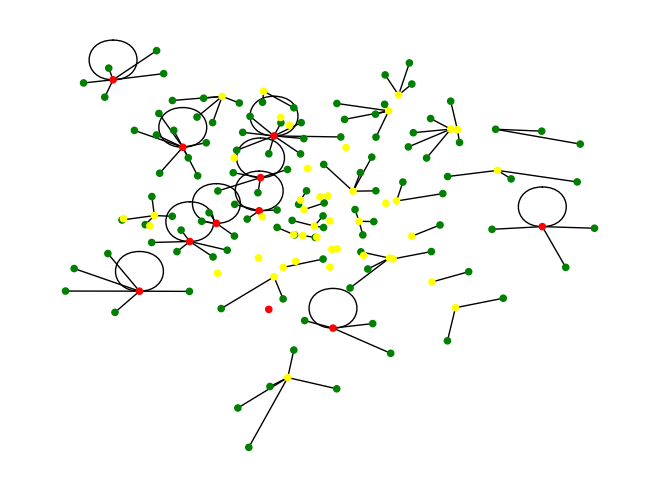

<Figure size 640x480 with 0 Axes>

In [141]:
for _, row in edge.iterrows():
    source = row['Source']
    target = row['Target']
    G.add_edge(source, target)

# Draw nodes
pos = nx.get_node_attributes(G, 'pos')
colors = nx.get_node_attributes(G, 'color').values()
nx.draw(G, pos, node_color=list(colors), with_labels=False, node_size=20)

# Show plot
plt.show()
plt.savefig('graph_image2.png')

In [136]:
plt.savefig('graph_image.png')

<Figure size 640x480 with 0 Axes>